Here I am going to make a simple Graph Neural Network.

In [2]:
# Installing the Libraries:

%pip install dgl-cu116 dglgo -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 227.0 MB 3.0 MB/s eta 0:00:01     |██████████▎                     | 73.3 MB 44.7 MB/s eta 0:00:04     |██████████▌                     | 74.7 MB 44.7 MB/s eta 0:00:04███                   | 91.6 MB 1.8 MB/s eta 0:01:17     |████████████████████████▍       | 173.0 MB 9.5 MB/s eta 0:00:06
     |████████████████████████████████| 77 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 53.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.7 MB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 59.5 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 92.5 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 31.4 MB/s eta 0:00:01
     |████████████████████████████████| 570 kB 74.1 MB/s eta 0:

In [4]:
import dgl
import dgl.data


dataset = dgl.data.CoraGraphDataset()

print(f'Number of Categories: {dataset.num_classes}')

print(f'Number of Graphs: {len(dataset)}')


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of Categories: 7
Number of Graphs: 1


In [32]:
# If we had a molecular dataset there would be multiple graphs here!
g = dataset[0] # get the graph from the dataset.

# Features for the nodes:
print(f"Node features: {g.ndata.keys()}")
print(f"Edge features: {g.edata.keys()}")

Node features: dict_keys(['feat', 'label', 'test_mask', 'val_mask', 'train_mask'])
Edge features: dict_keys(['__orig__'])


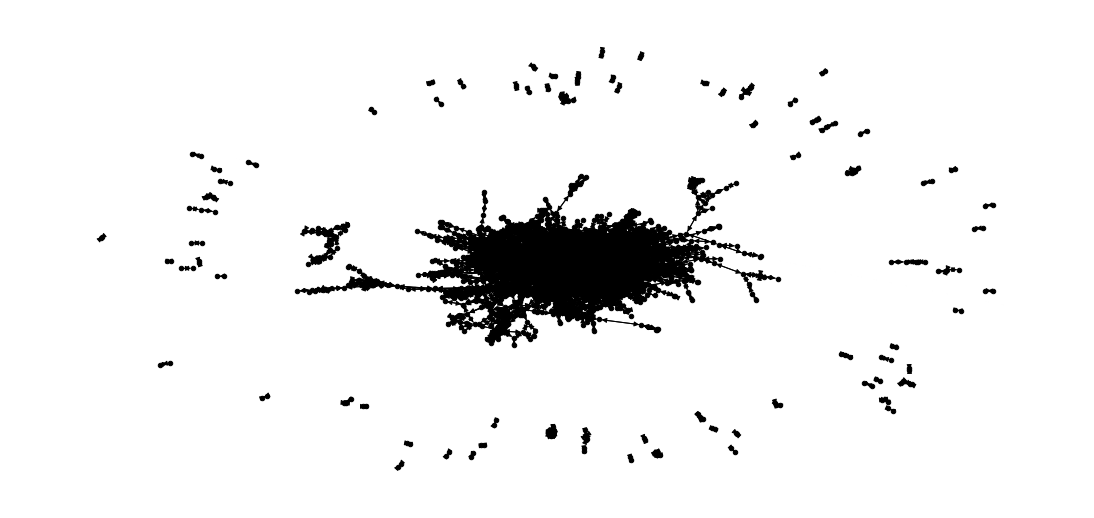

In [18]:
# Lets visualize the Graph!
import matplotlib.pyplot as plt
import networkx as nx

# Networkx is a graph library for Python.
G = dgl.to_networkx(g)

plt.figure(figsize=(15, 7))

options = {
    "node_color": 'black',
    'node_size': 20,
    'width': 1
}

nx.draw(G, **options)


In [36]:
g.num_nodes()

2708

In [38]:
shapeOfNodeFeatures = g.ndata['feat'].shape
print(f'Shape of features: {shapeOfNodeFeatures}')

shapeOfNodeLabels = g.ndata['label'].shape
print(f'Shape of node labels: {shapeOfNodeLabels}')

print(f'Node Count: {g.num_nodes()}')

# there are 2708 nodes and each node has 1433 features.

Shape of features: torch.Size([2708, 1433])
Shape of node labels: torch.Size([2708])
Node Count: 2708


In [29]:
len(g.nodes) # There are 10 nodes.
len(g.edges) # There are 26 edges.

26

In [26]:
# Lets generate a random graph:

from networkx.generators.random_graphs import erdos_renyi_graph

n = 10

p = 0.5

g = erdos_renyi_graph(n, p)

nx.adjacency_matrix(g).todense()

matrix([[0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0]])

### GraphConv

There are two things in a graph:

1. The graph structure itself, which is usually shown using an adjacency matrix $A$

2. The features of every node which shown by $N \times D$ matrix where $N$ is equal to the number of nodes and $D$ is equal to the number of features that each node has.

$A_{N \times N}$ -> Adjacency Matrix

$X_{N \times D}$ -> Feature Matrix

So our neural network should take both $A$ and $X$ as the input.

and then return a $N \times F$ matrix that has $F$ features for each node.

We can make a single layer neural network like so:

$$O_{N \times F} = f(X_{N \times D}, A_{N \times N})$$

What is $f$?

$$f(X, A) = \sigma(A_{N \times N}X_{N \times D}W_{D \times F})$$

1. $W_{D \times F}$ weights of the NN.
2. $\sigma$ is the *ReLU* function.

There are two problems with this architecture:

1. If we multiple the features by the adjacency matrix we will lose any data
that is associated to the node itself because it will get multipled by 0.
2. A is not normalized! Then if we multiple our graph by $A$ we will get a value is that might not be as good as we wanted it to be.



What is a GraphConv?

So for the 

We first calculate a Hidden state using the following formula:

$$H^{(l + 1)} = f(H^{(l)}, A) $$


In [22]:
# Graph Convolutional Neural Network:

from dgl.nn import GraphConv
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()

        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feats):
        h = self.conv1(g, in_feats)
        h = F.relu(h)
        h = self.conv2(g, h)

        return h

model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [41]:
def train(g, model, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    features = g.ndata['feat']
    labels = g.ndata['label']

    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']

    for e in range(epochs):
        logits = model(g, features)

        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        print(f'Epoch {e} Done!')

train(g, model, 100)


Epoch 0 Done!
Epoch 1 Done!
Epoch 2 Done!
Epoch 3 Done!
Epoch 4 Done!
Epoch 5 Done!
Epoch 6 Done!
Epoch 7 Done!
Epoch 8 Done!
Epoch 9 Done!
Epoch 10 Done!
Epoch 11 Done!
Epoch 12 Done!
Epoch 13 Done!
Epoch 14 Done!
Epoch 15 Done!
Epoch 16 Done!
Epoch 17 Done!
Epoch 18 Done!
Epoch 19 Done!
Epoch 20 Done!
Epoch 21 Done!
Epoch 22 Done!
Epoch 23 Done!
Epoch 24 Done!
Epoch 25 Done!
Epoch 26 Done!
Epoch 27 Done!
Epoch 28 Done!
Epoch 29 Done!
Epoch 30 Done!
Epoch 31 Done!
Epoch 32 Done!
Epoch 33 Done!
Epoch 34 Done!
Epoch 35 Done!
Epoch 36 Done!
Epoch 37 Done!
Epoch 38 Done!
Epoch 39 Done!
Epoch 40 Done!
Epoch 41 Done!
Epoch 42 Done!
Epoch 43 Done!
Epoch 44 Done!
Epoch 45 Done!
Epoch 46 Done!
Epoch 47 Done!
Epoch 48 Done!
Epoch 49 Done!
Epoch 50 Done!
Epoch 51 Done!
Epoch 52 Done!
Epoch 53 Done!
Epoch 54 Done!
Epoch 55 Done!
Epoch 56 Done!
Epoch 57 Done!
Epoch 58 Done!
Epoch 59 Done!
Epoch 60 Done!
Epoch 61 Done!
Epoch 62 Done!
Epoch 63 Done!
Epoch 64 Done!
Epoch 65 Done!
Epoch 66 Done!
Epoch